In [2]:
import torch
from simulator import Market
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.analysis import pairplot
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statistics as stats
import json

In [164]:
#pick the true parameters
param_1 = 0.7 #sigma_eta
param_2 = 0.7 #beta
#lower and upper bounds for the prior
param_1_bounds = [0.1, 2]
param_2_bounds = [0.1, 2]
param_1_name = "theta_sigma"
param_2_name = "gamma_sigma"

In [3]:
#Define the simulators
def simulator_base(prior_sample):
    #access the first prior value from the tensor
    #create a dcitionary with the prior sample
    params = {param_1_name: float(prior_sample[0]), 
              param_2_name: float(prior_sample[1])}
    #run the market simulation
    market = Market(params)
    while market.step_count < market.total_steps:
        market.next_step()
    #compute the financial market return
    market_return = np.asarray(market.history_p_t)[1:]/np.asarray(market.history_p_t)[:-1] - 1
    # compute the variance, skewness and kurtosis of the market return
    variance = np.var(market_return)
    skewness = np.mean(((market_return - np.mean(market_return)) / np.std(market_return)) ** 3)
    kurtosis = np.mean(((market_return - np.mean(market_return)) / np.std(market_return)) ** 4)
    return torch.tensor([skewness, kurtosis])

def simulator_returns(prior_sample):
     #access the first prior value from the tensor
    #create a dcitionary with the prior sample
    params = {param_1_name: float(prior_sample[0]), 
              param_2_name: float(prior_sample[1])}
    #run the market simulation
    market = Market(params)
    while market.step_count < market.total_steps:
        market.next_step()
    #compute the financial market return
    market_return = np.asarray(market.history_p_t)[1:]/np.asarray(market.history_p_t)[:-1] - 1
    return torch.tensor(market_return)

In [4]:
#load the saved posterior
posterior1 = torch.load('posterior_model_theta_gamma.pt')

# Calibration on synthetic data

In [322]:
observation = simulator_base(torch.tensor([param_1, param_2]))

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

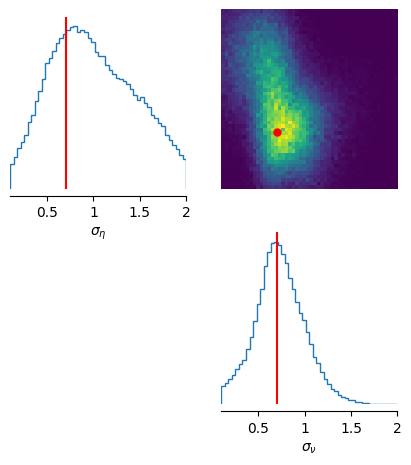

In [337]:
posterior_samples = posterior1.sample((100000,), x=observation)

# plot posterior samples
fig, ax = pairplot(
    posterior_samples, limits=[param_1_bounds, param_2_bounds], figsize=(5, 5),
    points=[np.array([param_1, param_2])],
                      points_colors='r', labels=[r'$\sigma_{\eta}$', r'$\sigma_{\nu}$']
)
plt.savefig('Figures/posterior_samples_synthetic.png')

In [332]:
#implied_data = simulator_returns(torch.tensor([theta_sigma, gamma_sigma, epsilon_sigma, ar_1_coefficient])).numpy()
implied_data = simulator_returns(torch.tensor(np.median(posterior_samples.numpy(), axis=0))).numpy()
actual_data = simulator_returns(torch.tensor([param_1, param_2])).numpy()
#compute skew and kurtosis of the implied data
skew = np.mean(((implied_data - np.mean(implied_data)) / np.std(implied_data)) ** 3)
kurt = np.mean(((implied_data - np.mean(implied_data)) / np.std(implied_data)) ** 4)

#compare with skew and kurtosis of the true data
true_data_skew = observation.numpy().flatten()[0]
true_data_kurt = observation.numpy().flatten()[1]

print("Skewness of the true data: ", true_data_skew)
print("Kurtosis of the true data: ", true_data_kurt)
print("Skewness of the implied data: ", skew)
print("Kurtosis of the implied data: ", kurt)

Skewness of the true data:  0.1359968036157783
Kurtosis of the true data:  3.9525104799314827
Skewness of the implied data:  0.17271136520230174
Kurtosis of the implied data:  3.693051252107779


# Calibration on real data

In [5]:
# get the data for TESLA on a daily basis
data = yf.download('TSLA', start='2023-09-01', end='2024-10-01')

[*********************100%%**********************]  1 of 1 completed


In [6]:
#compute returns 
data['Return'] = data['Close'].pct_change()

#compute the variance, skewness and kurtosis of the market return
variance = np.var(data['Return'])
skewness = np.mean(((data['Return'] - np.mean(data['Return'])) / np.std(data['Return'])) ** 3)
kurtosis = np.mean(((data['Return'] - np.mean(data['Return'])) / np.std(data['Return'])) ** 4)

real_data = torch.tensor([ skewness, kurtosis])
real_data 


tensor([0.2563, 5.5429], dtype=torch.float64)

In [7]:
samples = posterior1.sample((100000,), x=real_data)
# log_probability = posterior.log_prob(samples, x=real_observation)
# _ = analysis.pairplot(samples, limits=[[0.01, 10], [0.01, 10], [0.01, 0.99], [0.01, 0.5],[0.01, 0.5]], figsize=(6, 6))
print(np.median(samples.numpy(), axis=0))

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

[0.8388765 1.3566972]


In [352]:
#save the median values to the .json file that we will use for the numerical simulation
with open('constants/base_params_small_world.json') as f:
    data = json.load(f)
    data['theta_sigma'] = np.median(samples.numpy(), axis=0)[0]
    data['gamma_sigma'] = np.median(samples.numpy(), axis=0)[1]
    #change the type from float32 to float
    data['theta_sigma'] = round(float(data['theta_sigma']),2)
    data['gamma_sigma'] = round(float(data['gamma_sigma']),2)
    f.close()
with open('constants/base_params_small_world.json', 'w') as f:
    json.dump(data, f)
    f.close()

In [353]:
#Do the same for the other models
#save the median values to the .json file that we will use for the numerical simulation
with open('constants/base_params_SBM.json') as f:
    data = json.load(f)
    data['theta_sigma'] = np.median(samples.numpy(), axis=0)[0]
    data['gamma_sigma'] = np.median(samples.numpy(), axis=0)[1]
    #change the type from float32 to float
    data['theta_sigma'] = round(float(data['theta_sigma']),2)
    data['gamma_sigma'] = round(float(data['gamma_sigma']),2)
    f.close()
with open('constants/base_params_SBM.json', 'w') as f:
    json.dump(data, f)
    f.close()

In [355]:
#save the median values to the .json file that we will use for the numerical simulation
with open('constants/base_params_scale_free_CIA.json') as f:
    data = json.load(f)
    data['theta_sigma'] = np.median(samples.numpy(), axis=0)[0]
    data['gamma_sigma'] = np.median(samples.numpy(), axis=0)[1]
    #change the type from float32 to float
    data['theta_sigma'] = round(float(data['theta_sigma']),2)
    data['gamma_sigma'] = round(float(data['gamma_sigma']),2)
    f.close()
with open('constants/base_params_scale_free_CIA.json', 'w') as f:
    json.dump(data, f)
    f.close()

In [356]:
#save the median values to the .json file that we will use for the numerical simulation
with open('constants/base_params_scale_free_CMA.json') as f:
    data = json.load(f)
    data['theta_sigma'] = np.median(samples.numpy(), axis=0)[0]
    data['gamma_sigma'] = np.median(samples.numpy(), axis=0)[1]
    #change the type from float32 to float
    data['theta_sigma'] = round(float(data['theta_sigma']),2)
    data['gamma_sigma'] = round(float(data['gamma_sigma']),2)
    f.close()
with open('constants/base_params_scale_free_CMA.json', 'w') as f:
    json.dump(data, f)
    f.close()

In [9]:
#get the mean, mode, 5% and 95% quantiles of the posterior by leveraging pandas
posterior_samples_df = pd.DataFrame(samples)
posterior_samples_df.describe()

,0,1
count,100000.000000,100000.000000
mean,0.894004,1.342497
std,0.475267,0.266986
min,0.100034,0.112737
25%,0.503914,1.177635
50%,0.838877,1.356697
75%,1.249796,1.526428
max,1.999917,1.999933


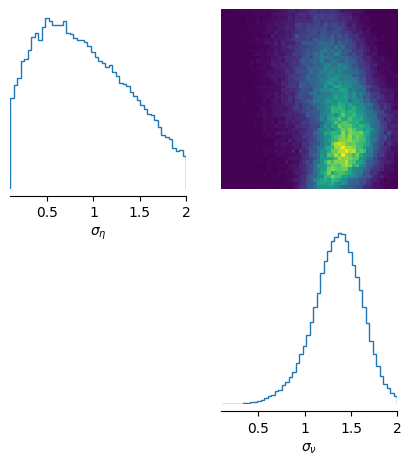

In [342]:
# plot posterior samples
fig, ax = pairplot(
    samples, limits=[param_1_bounds, param_2_bounds], figsize=(5, 5),
    #points=[np.median(samples.numpy(), axis=0)],
                      #points_colors='k',
    labels=[r'$\sigma_{\eta}$', r'$\sigma_{\nu}$']
)
# Save the figure
#plt.savefig('Figures/posterior_samples.png')

In [336]:
#compute simulated data for 1000 runs, with those parameters and compare with the real data
implied_data = [simulator_base(np.median(samples.numpy(), axis=0)) for _ in range(10)]
sim_skew, sim_kurt = np.median(implied_data, axis=0)


print("Skewness of the true data: ", real_data[0])
print("Kurtosis of the true data: ", real_data[1])
print("Skewness of the implied data: ", sim_skew)
print("Kurtosis of the implied data: ", sim_kurt)



Skewness of the true data:  tensor(0.2563, dtype=torch.float64)
Kurtosis of the true data:  tensor(5.5429, dtype=torch.float64)
Skewness of the implied data:  0.02813508444749916
Kurtosis of the implied data:  4.758463147653097


# Train the SNPE again

This part of the code should be run only if you want to retrain the Neural Approximator

In [165]:
# num_dim = 2
# #Define the prior
# prior = utils.BoxUniform(low=torch.tensor([param_1_bounds[0], param_2_bounds[0]]),
#                           high=torch.tensor([param_1_bounds[1], param_2_bounds[1]]))



In [166]:
# # Check prior, return PyTorch prior.
# prior, num_parameters, prior_returns_numpy = process_prior(prior)

# # Check simulator, returns PyTorch simulator able to simulate batches.
# simulator = process_simulator(simulator_base, prior, prior_returns_numpy)

# # Consistency check after making ready for sbi.
# check_sbi_inputs(simulator, prior)

# # Then, we instantiate the inference object
# inference = SNPE(prior=prior)

# theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10_000)

# inference = inference.append_simulations(theta, x)
# density_estimator = inference.train(force_first_round_loss=True)

# posterior = inference.build_posterior(density_estimator)

# #save the posterior to a torch file
# torch.save(posterior, 'posterior_model.pt')